Assignment 10 
Applied Machine Learning 
In this assignment, we will develop a ML model for cybersecurity intrusion detection. Please visit the website: https://www.unb.ca/cic/datasets/ids-2017.html and look around to see the problem space and the evaluation datasets to be used for ML model development. 
 
This dataset was collected by cyber experts during experimentation that was carried out over the course of 5 days. The description of the experiments also informs the experimental ground truth. 
(Suggested: GeneratedLabelledFlows.zip; note that it is already pre-processed by someone) 
 
1. [10 pts] Download the labeled dataset (if you like, use a dummy email address for registration). There must be 8 data files, each representing a particular cyber-attack type, its day, and its collected packet capture (“PCAP”) data. 

- [x] Done 

2. [10 pts] Pick one of the data files, call it Dataset 1, and examine its features. Make sure it has more than one class value for its label. 

In [1]:
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 10
pd.options.mode.chained_assignment = None
dataset_1 = "./TrafficLabelling/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
df1 = pd.read_csv(dataset_1)

## CHECK LABELS
n,f = df1.shape
classes = set(df1[" Label"])
assert len(classes) > 1

## CHECK FEATURES
sample = df1.iloc[0]
nans = 100 * df1.isna().sum() / len(df1)
print(pd.concat(
    (sample, df1.dtypes, nans, df1.nunique(), df1.min(), df1.max()), 
    keys=["Sample", "Datatype", "NaN %", "Unique", "Min", "Max"], 
    axis=1).drop("Flow ID")
)
## DROP INVALID VALUES (inf)
import numpy as np
df1["Flow Bytes/s"][df1["Flow Bytes/s"] == np.inf] = np.nan
df1 = df1.dropna()

                                      Sample Datatype     NaN %  Unique  \
 Source IP                    104.16.207.165   object  0.000000    2067   
 Source Port                             443    int64  0.000000   50697   
 Destination IP                 192.168.10.5   object  0.000000    2554   
 Destination Port                      54865    int64  0.000000   23950   
 Protocol                                  6    int64  0.000000       3   
 Timestamp                     7/7/2017 3:30   object  0.000000      93   
 Flow Duration                             3    int64  0.000000  187752   
 Total Fwd Packets                         2    int64  0.000000     297   
 Total Backward Packets                    0    int64  0.000000     367   
Total Length of Fwd Packets               12    int64  0.000000    3831   
 Total Length of Bwd Packets               0    int64  0.000000    6760   
 Fwd Packet Length Max                     6    int64  0.000000    1891   
 Fwd Packet Length Min   

3. [10 pts] For your Dataset 1, pick a machine learning methodology and justify your choice. 

Observations: The dataset labels imply a supervised binary classification problem. Almost all of the (85) features are already in a numeric form and are non-categorical. There are a very large number of samples (225,745) compared to previous datasets we have analyzed so far. 

Many features have a very wide range from their min to max value, and since I have no experience with cyber security, I am not sure what the best approach would be for normalization. Thus for a first past I'm ruling out methods like SVM, Neural Networks, and Logistic Regression that are heavily influenced by feature scales. 

There are a large number features, and many of them seem highly related purely based on names and the distribution of values they hold (i.e. non-independent). This means Naïve Bayes would be a poor choice without heavy investigation and pruning of the features. 

Since this dataset has a large number of unfamiliar features and a large number of samples, I believe an ensemble would be best initial approach, and of the remaining options, Random Forest would be the most straightforward to implement. 

4. [10 pts] Process the class feature/category as binary classes for supervised learning, assign BENIGN to value 0 and the rest to value 1. Check its balance for the Dataset 1. 

In [2]:
## CHECK CLASS BALANCE
class_balance = {key: round(100*len(df1[df1[" Label"] == key])/n, 3) for key in classes}
print("CLASS BALANCE PERCENTAGES:", class_balance)
df1[" Label"][df1[" Label"] != "BENIGN"] = 1
df1[" Label"][df1[" Label"] == "BENIGN"] = 0
df1[" Label"] = df1[" Label"].astype(int)

CLASS BALANCE PERCENTAGES: {'DDoS': 56.712, 'BENIGN': 43.273}


5. [10 pts] Explore Dataset 1 features with respect to the class. (Hint: features Source Port and Destination Port are very useful; research and find out important networking port numbers and one-hot-encode them. Unimportant port numbers or source port numbers can be assigned to a feature called 'other ports'.) 

In [3]:
## PORT CATEGORIES
## 0 to 1023      -> System services/network protocol ports
## 1024 to 49151  -> Registered ports
## 49152 to 65535 -> Dynamic/Private ports

## RELEVANT PORTS FOR DDoS ATTACKS:
## [source] https://blog.netwrix.com/2022/08/04/open-port-vulnerabilities-list/ 
ports = [
    20, 21, ## FTP: File Transfer Protocol ports that let users send and receive files from servers.
    22,     ## SSH: A TCP port for ensuring secure access to servers. Hackers can exploit port 22 by using leaked SSH keys or brute-forcing credentials.
    25,     ## SMTP: DDoS attacks targeting email servers might focus on SMTP ports to flood the server with spam emails or connection attempts.
    53,     ## DNS: DNS amplification attacks exploit misconfigured DNS servers to generate large volumes of traffic directed towards the victim's network.
    80, 443, 8080, 8443, ## HTTP/HTTPS: DDoS attacks targeting web servers often focus on these ports to flood the server with HTTP/HTTPS requests, exhausting its resources and causing denial of service.
    123,    ## NTP: Network Time Protocol (NTP) reflection attacks abuse NTP servers to amplify attack traffic towards the victim, overwhelming their resources.
    161,    ## SNMP: Simple Network Management Protocol (SNMP) reflection attacks abuse SNMP-enabled devices to amplify attack traffic towards the victim.
    1900,   ## SSDP: Simple Service Discovery Protocol (SSDP) reflection attacks exploit vulnerable SSDP-enabled devices to amplify DDoS traffic.
    5060,   ## VoIP/SIP: DDoS attacks targeting Voice over IP (VoIP) services often exploit SIP (Session Initiation Protocol) to flood the service with SIP requests, causing disruption.
    "system",
    "registered",
    "dynamic",
]
def encode_port(port):
    if port in ports:
        return ports.index(port)
    elif port >= 0 and port < 1024:
        return ports.index("system")
    elif port >= 1024 and port < 49152:
        return ports.index("registered")
    elif port >= 49152:
        return ports.index("dynamic")

df1[" Source Port"] = df1[" Source Port"].apply(encode_port)
df1[" Destination Port"] = df1[" Destination Port"].apply(encode_port)
## WILL REPLACE NUMERIC VALUE WITH ONE-HOT LATER

6. [10 pts] Display some histograms and anything you deem fit to pick independent Dataset 1 features. (Hint: source/destination bytes, packets, ports and the duration features.) 

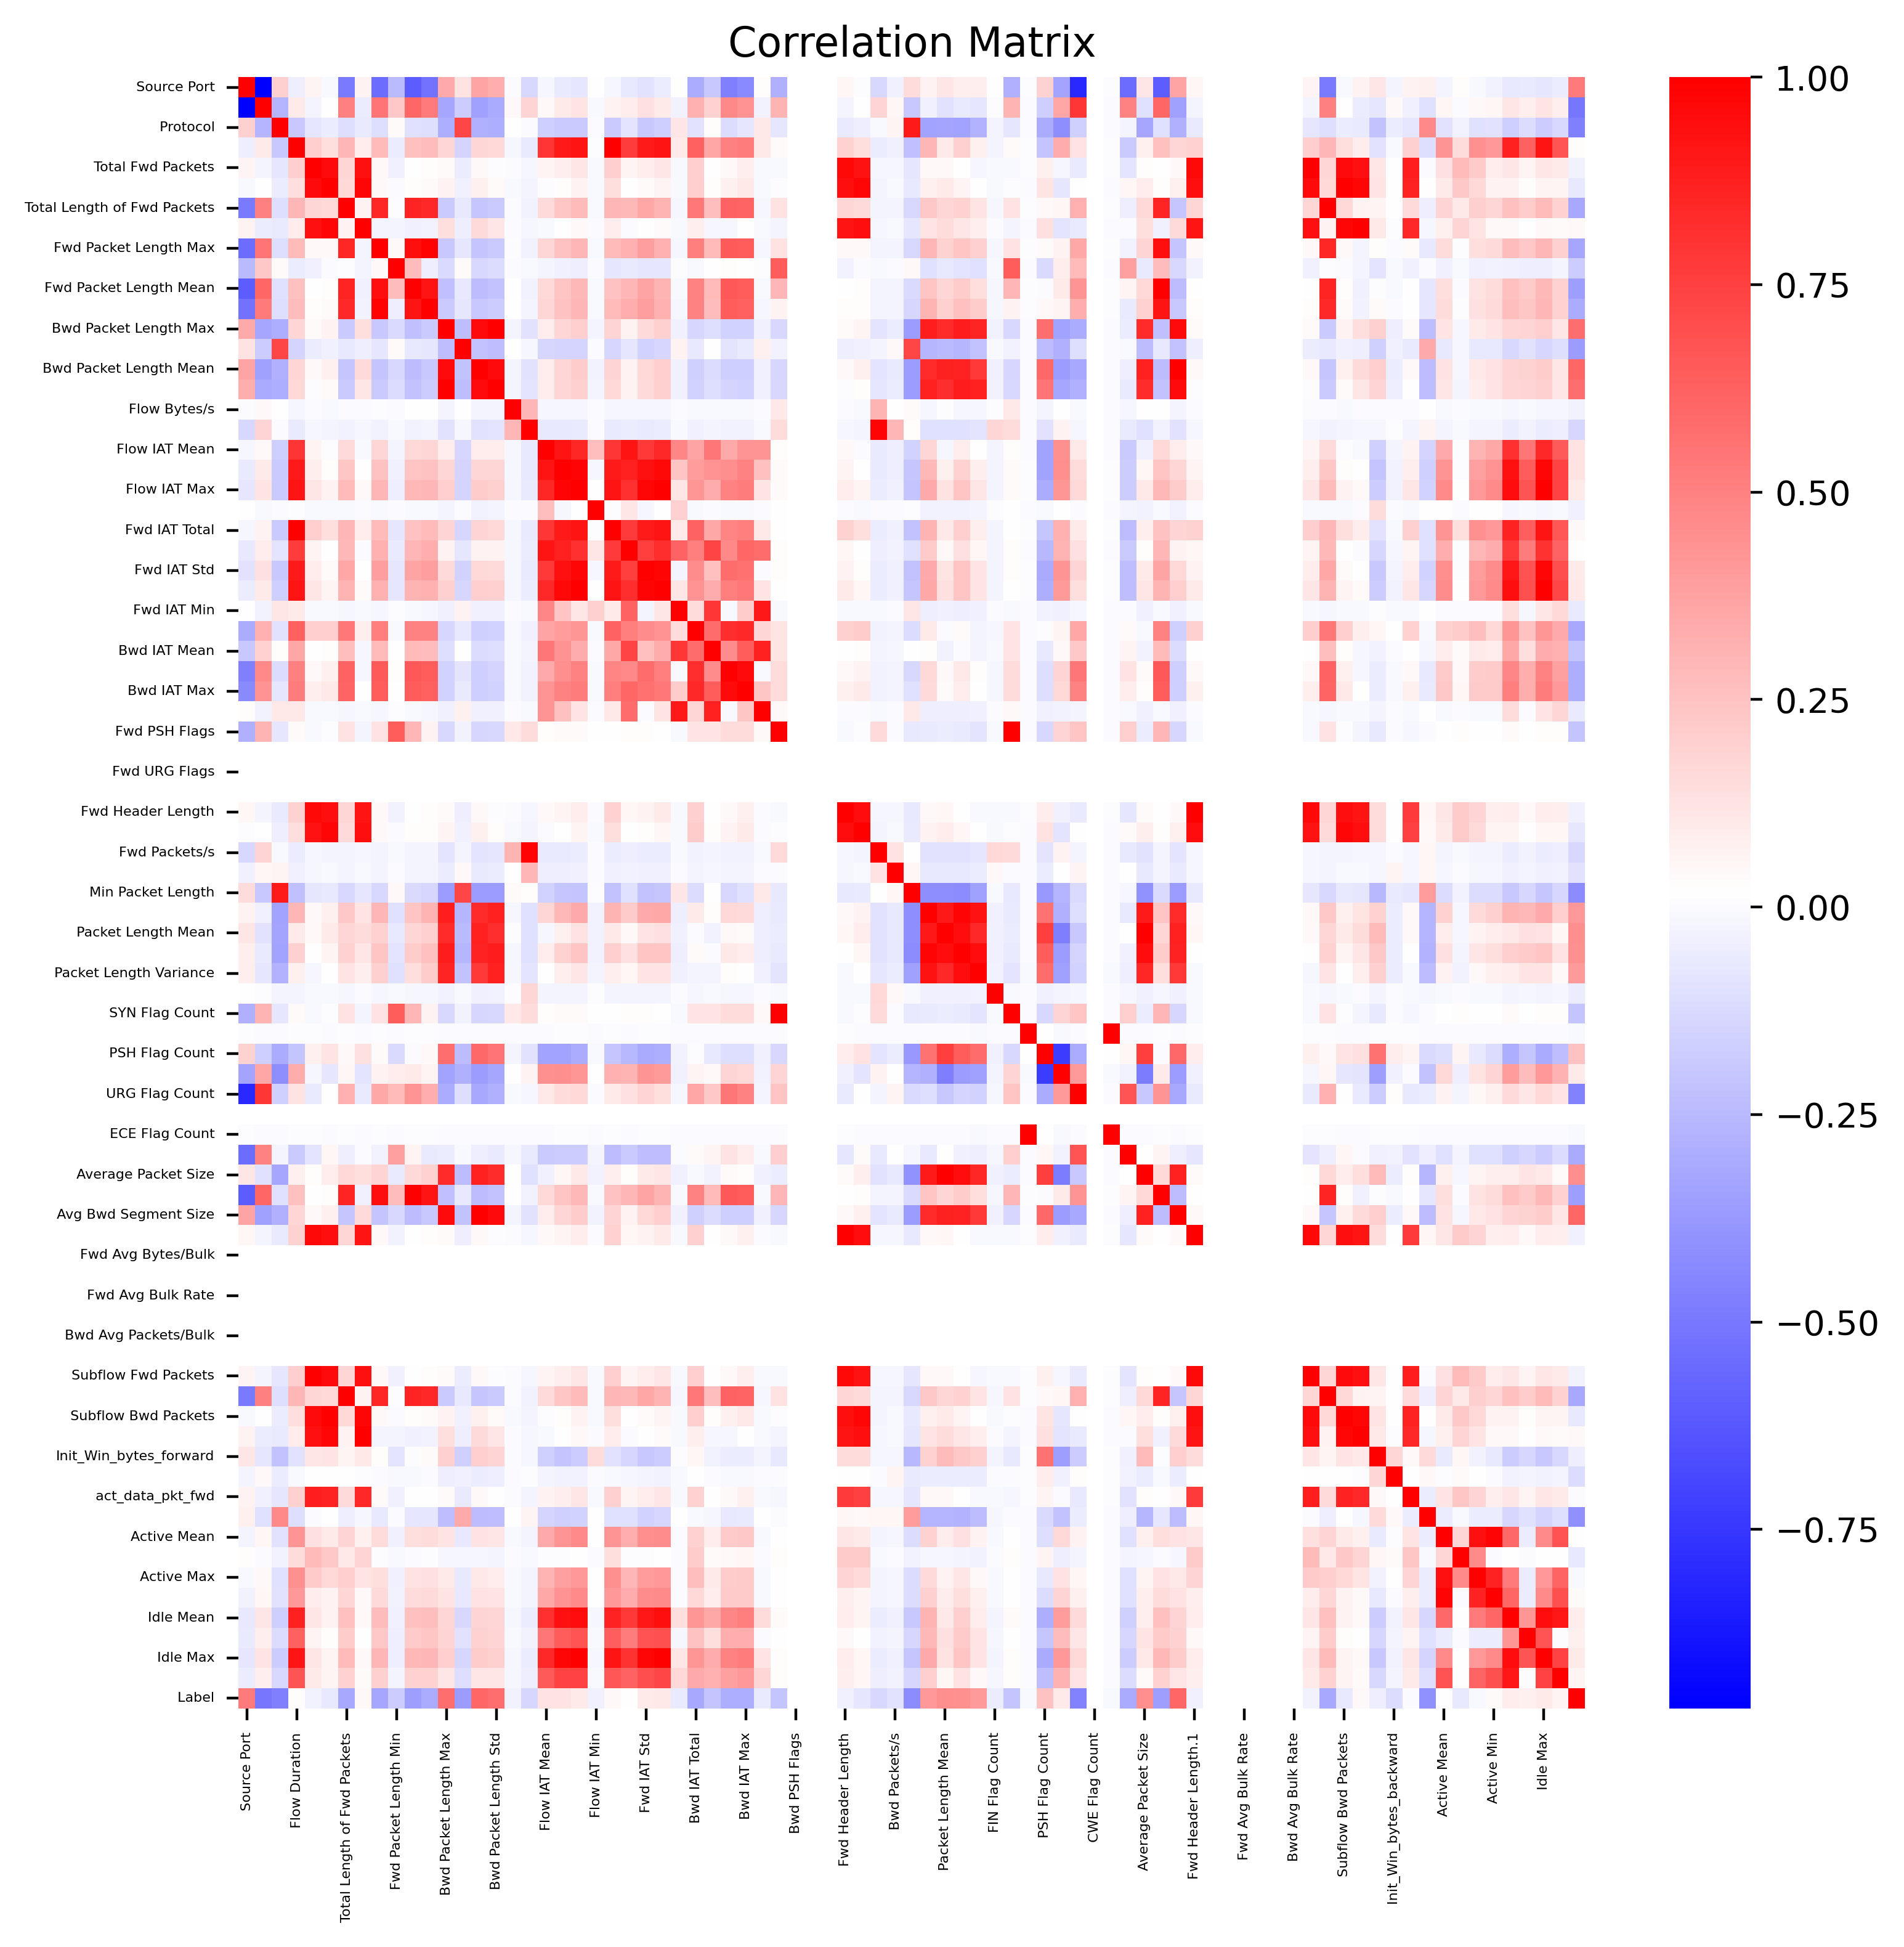

In [4]:
## PLOT CORRELATION MATRIX AND PLOT HISTOGRAMS OF MOST RELEVANT FEATURES
%matplotlib inline
import matplotlib.pyplot as plt

def remove_outliers(df, col):
    return df[df[col].abs() < 3*df[col].std()]

def plot_hist(df, col):
    df[col].hist(bins=20)
    plt.title(col)
    plt.xlabel(f"{col} values")
    plt.ylabel("Occurances")
    plt.tight_layout()

## PLOT CORRELATION MATRIX
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["figure.dpi"] = 400
heatmap = sns.heatmap(df1.corr(), cmap="bwr")
heatmap.set_title("Correlation Matrix")
heatmap.tick_params(axis='both', which='major', labelsize=4)
heatmap.tick_params(axis='both', which='minor', labelsize=4)
plt.tight_layout()

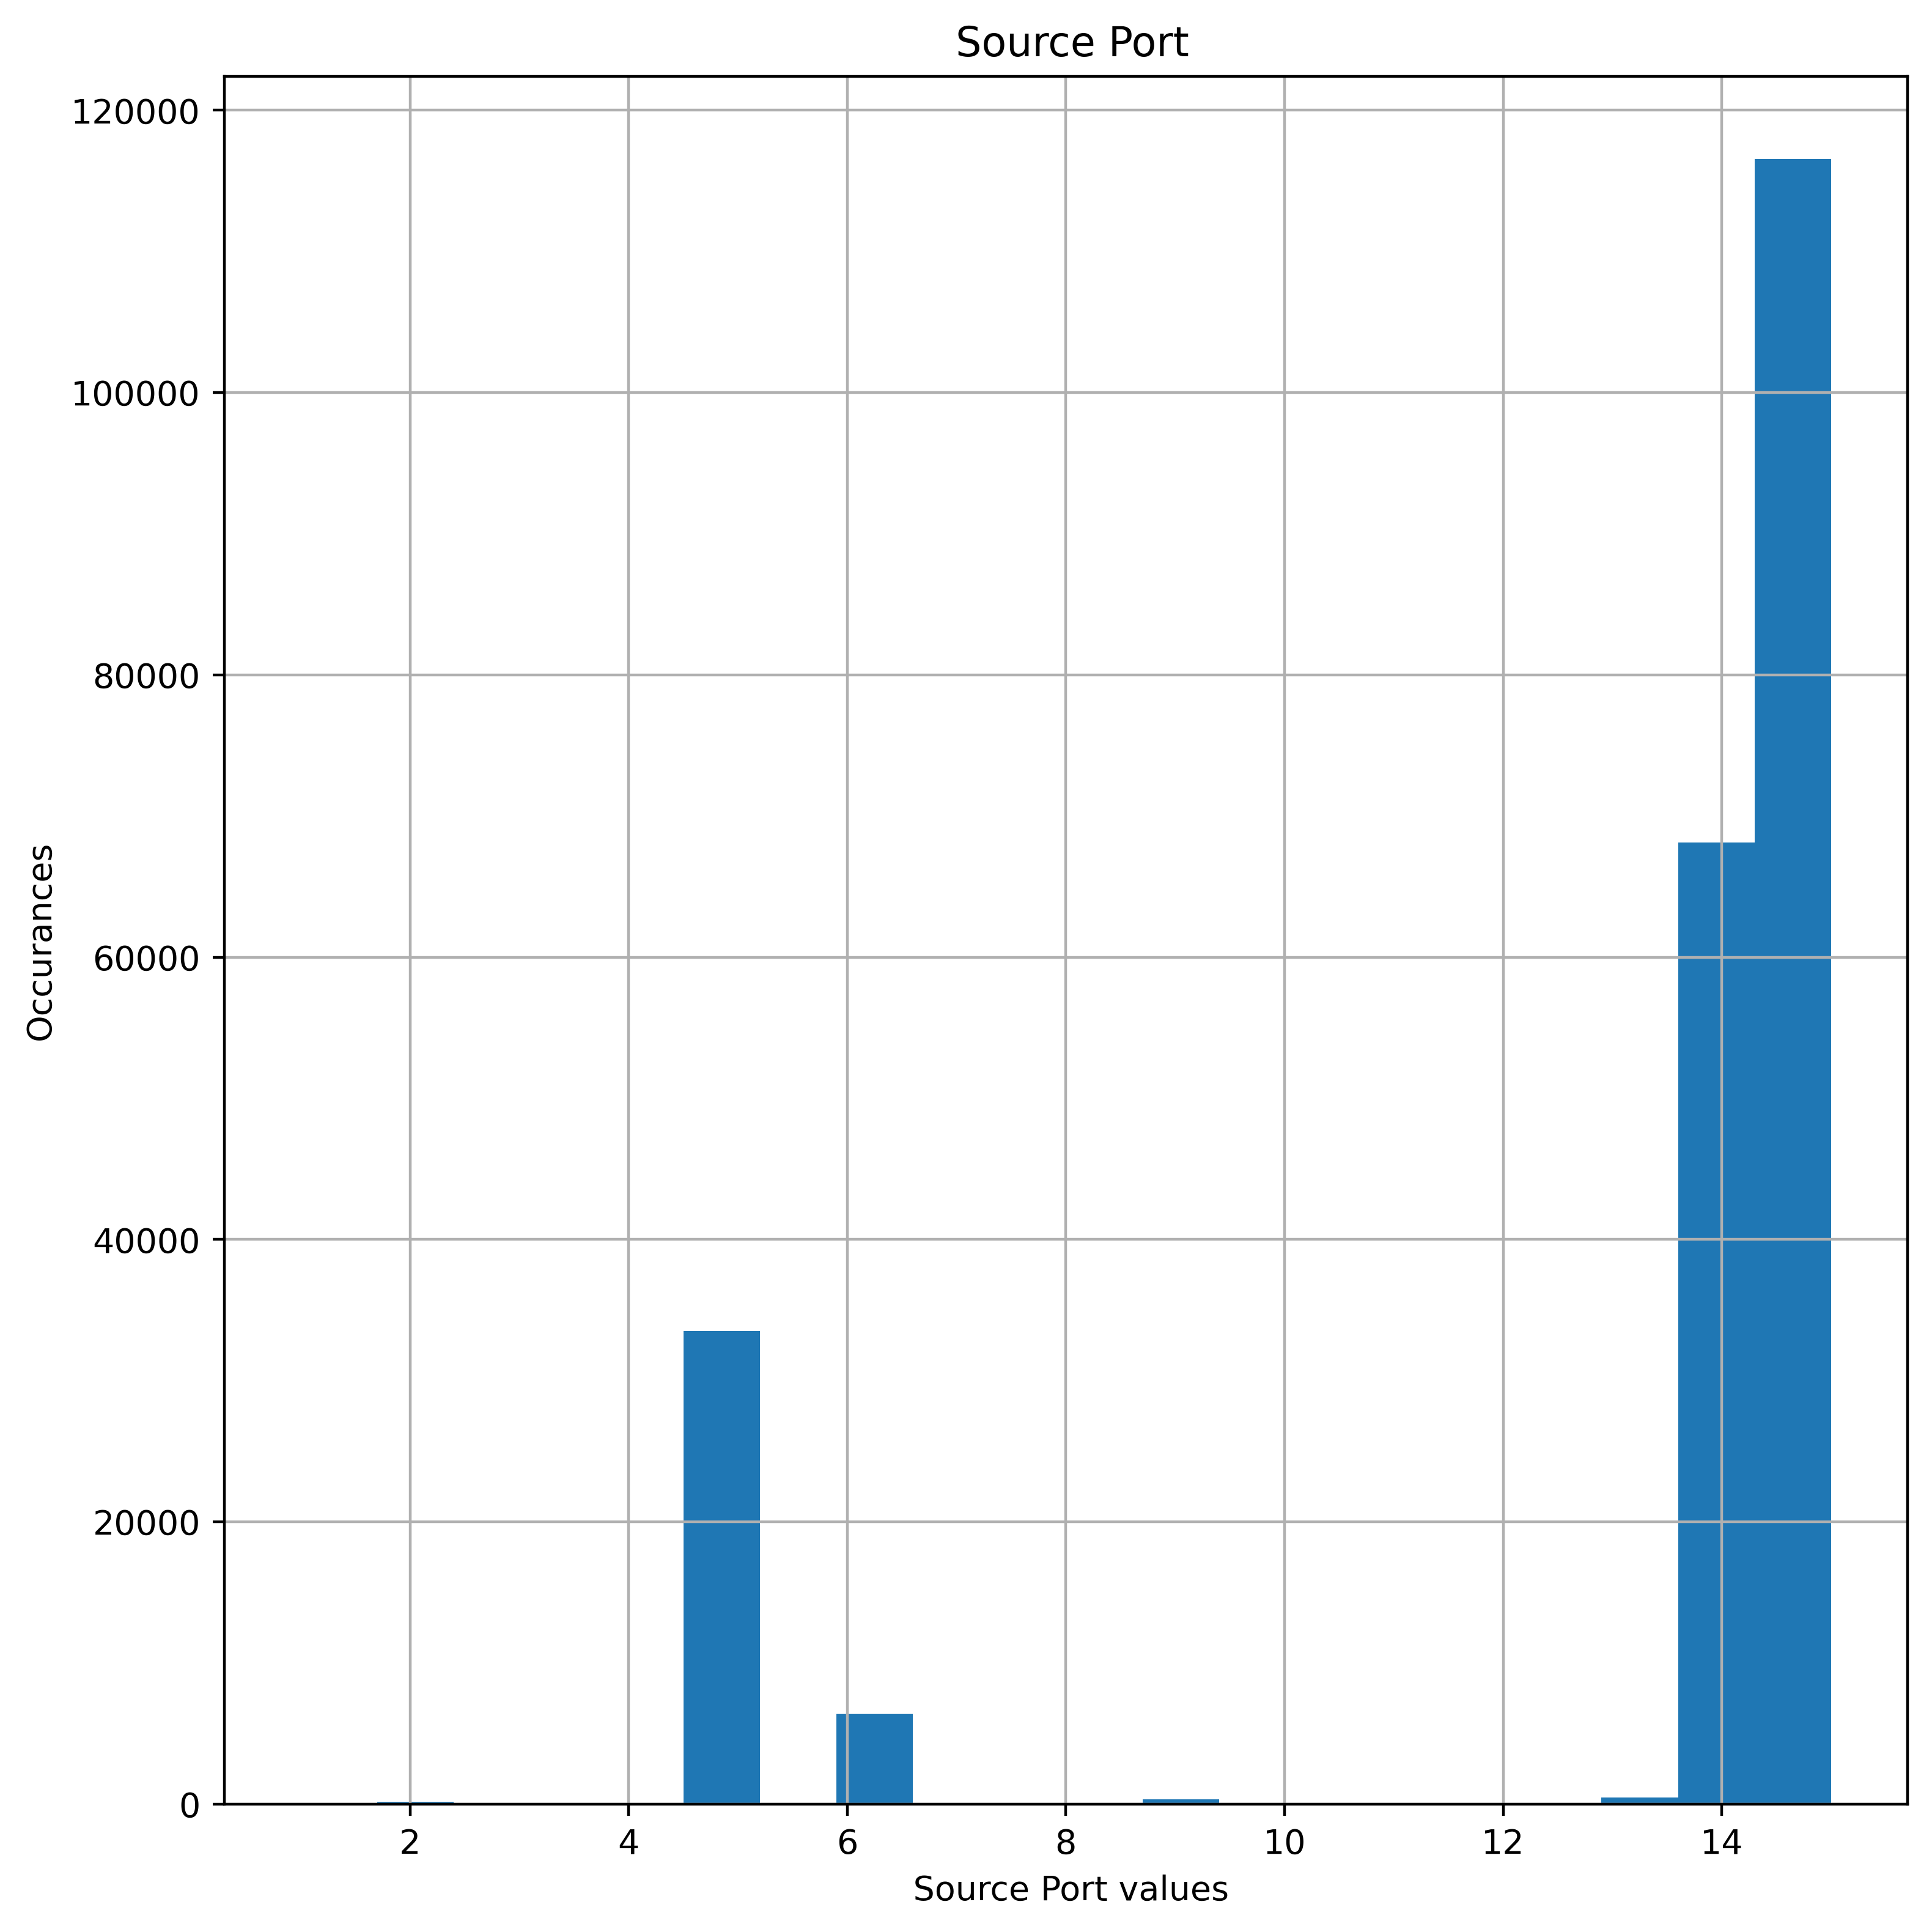

In [5]:
plot_hist(df1, " Source Port")

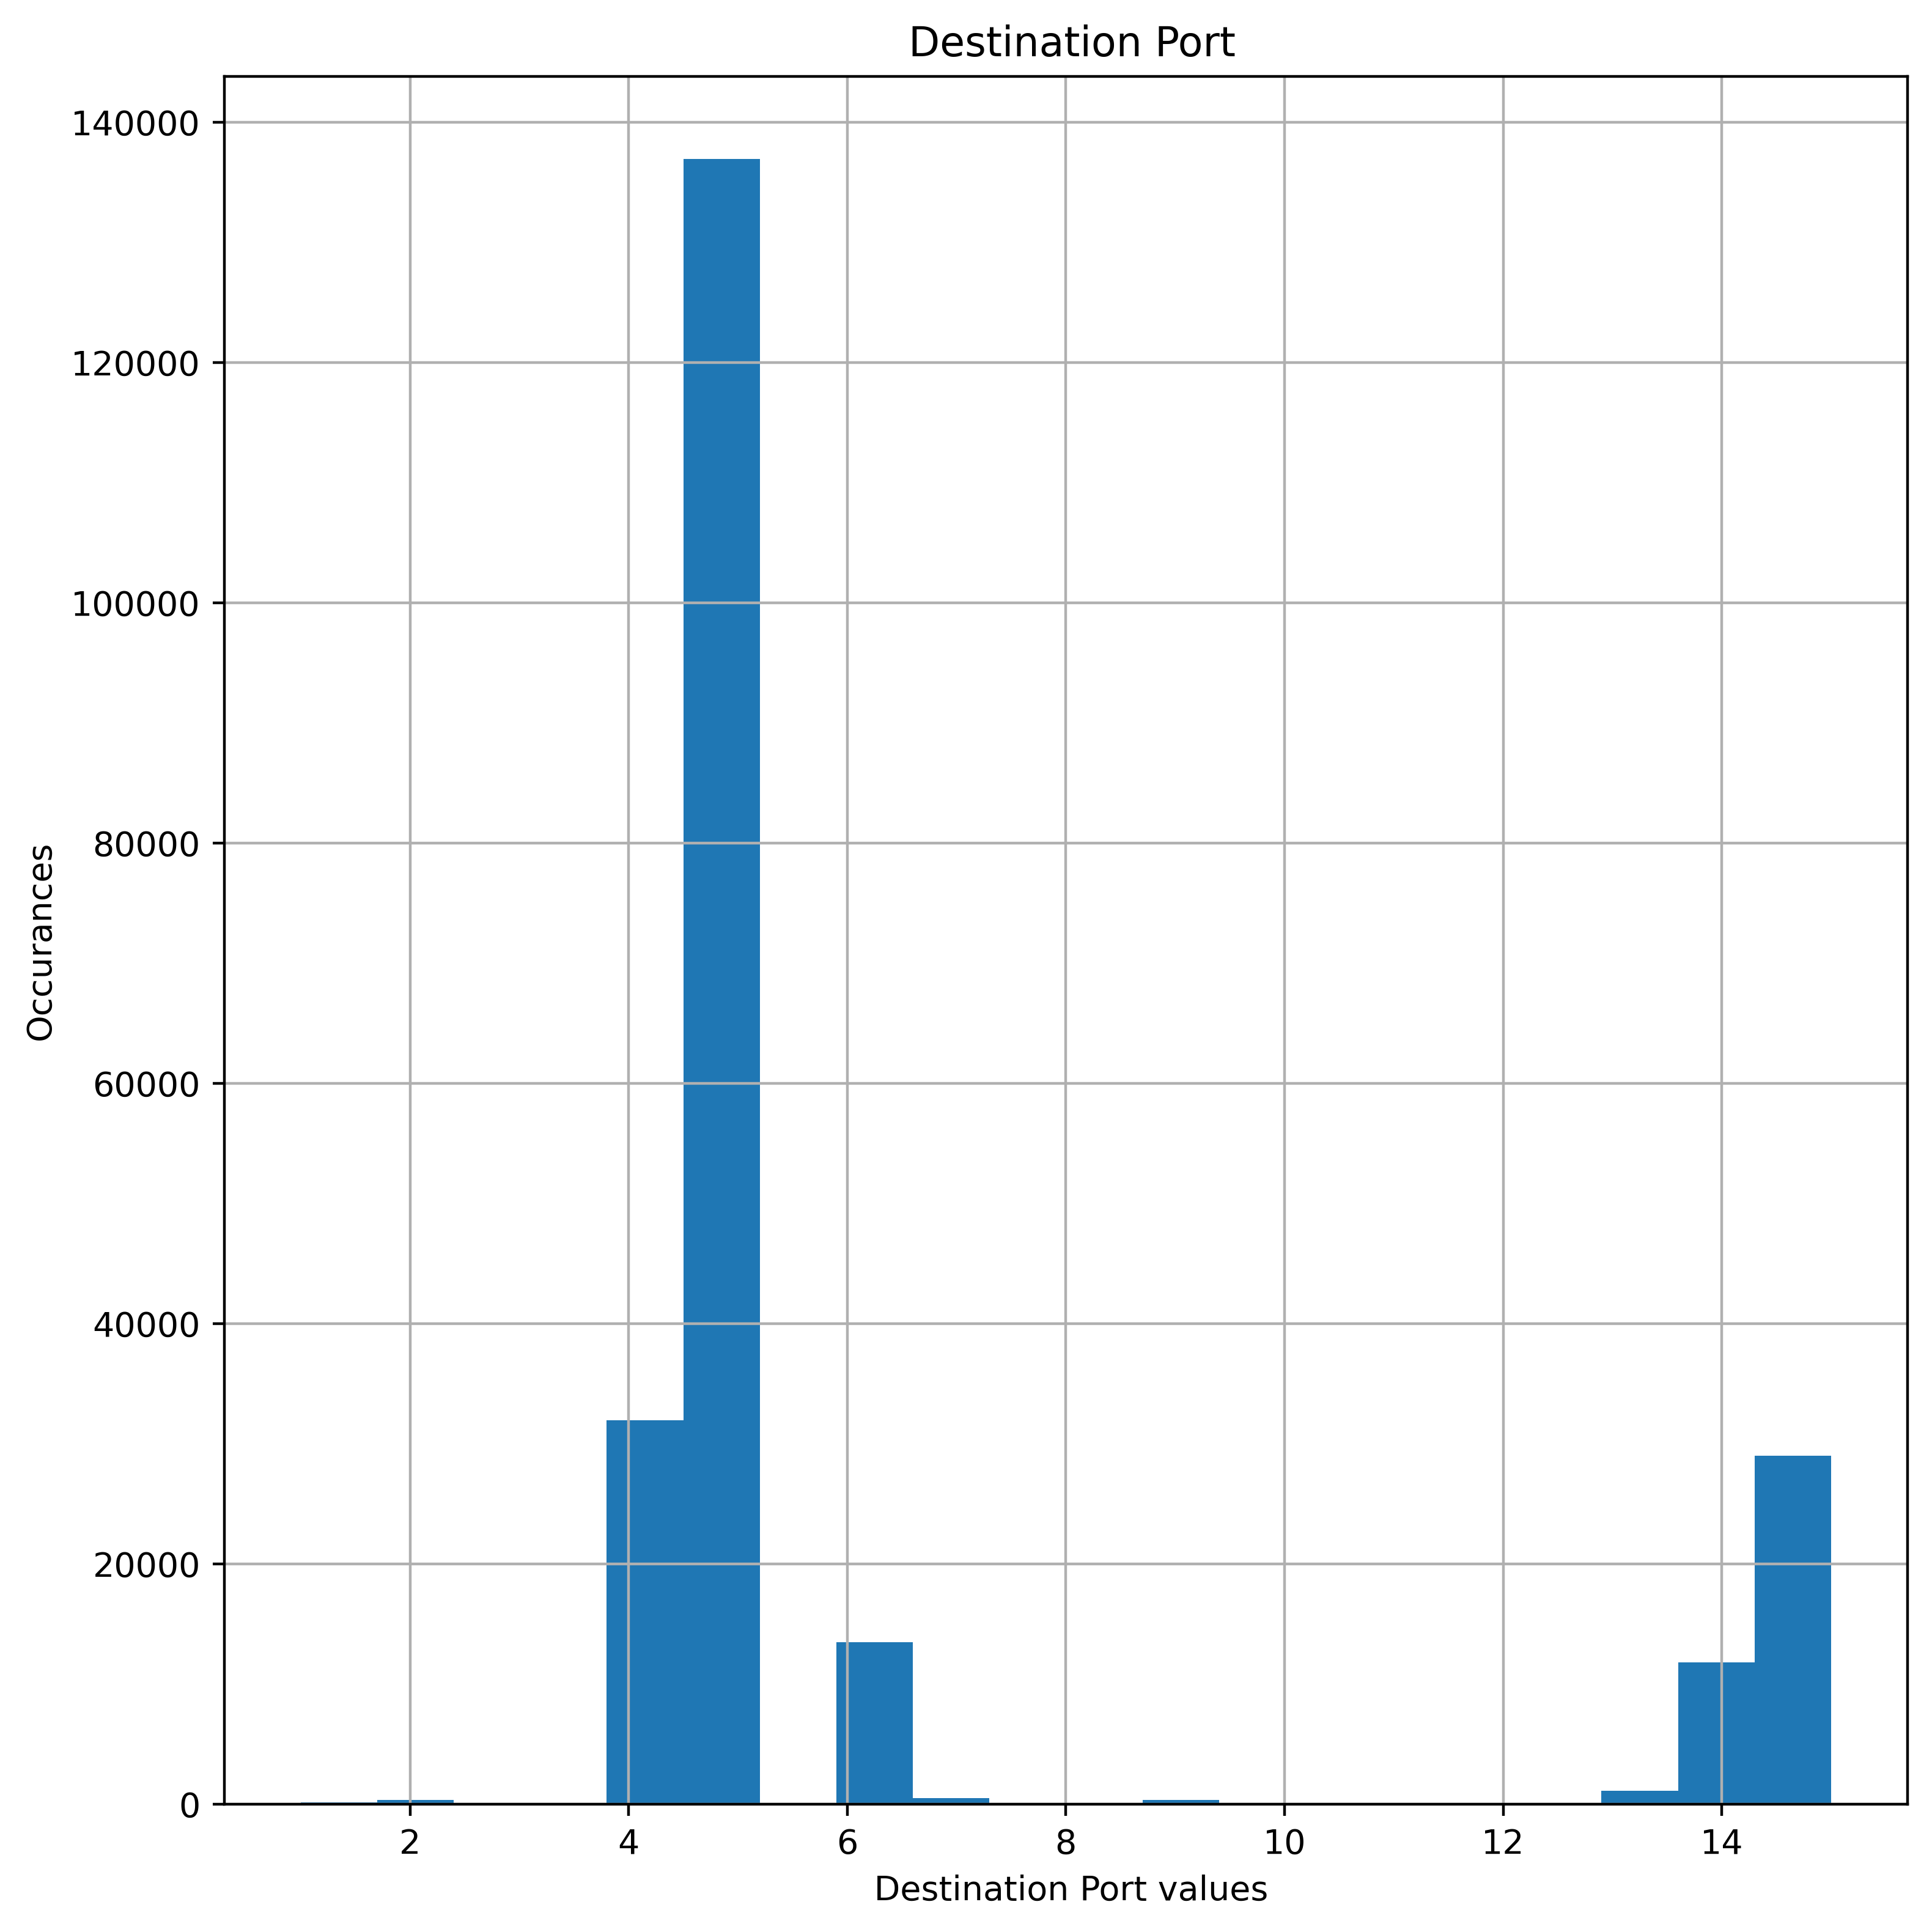

In [6]:
plot_hist(df1, " Destination Port")

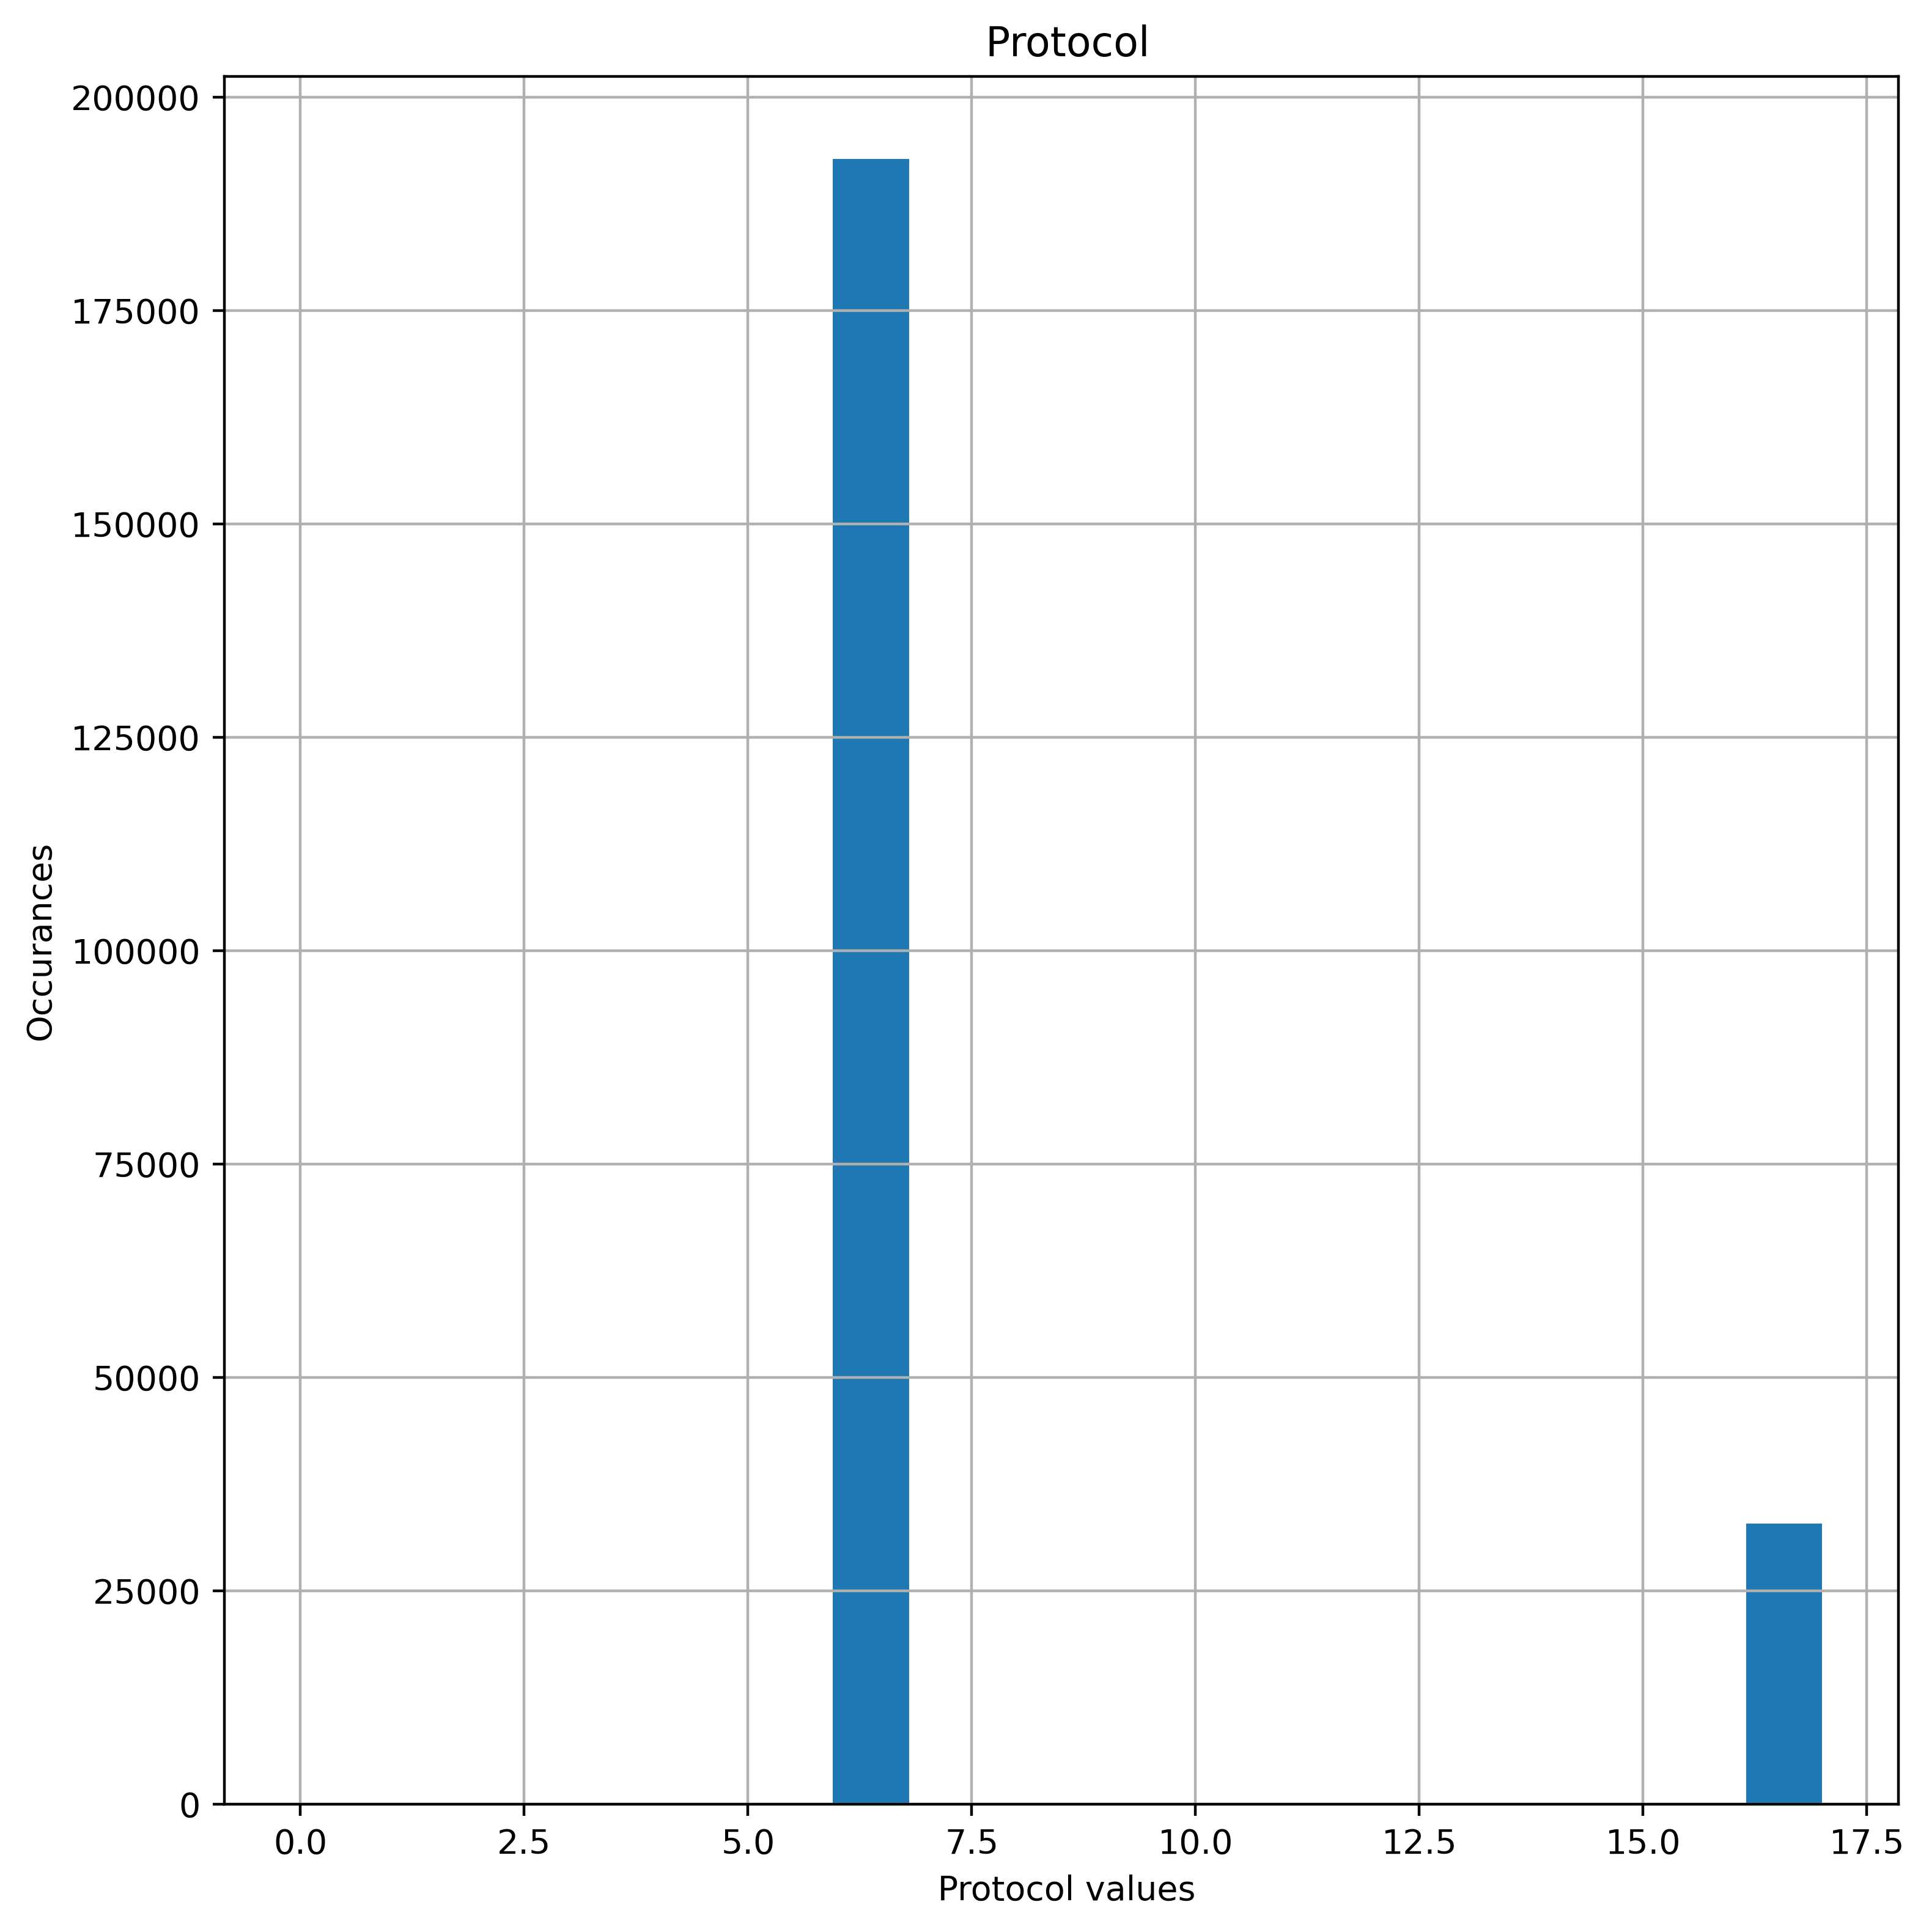

In [7]:
plot_hist(df1, " Protocol")

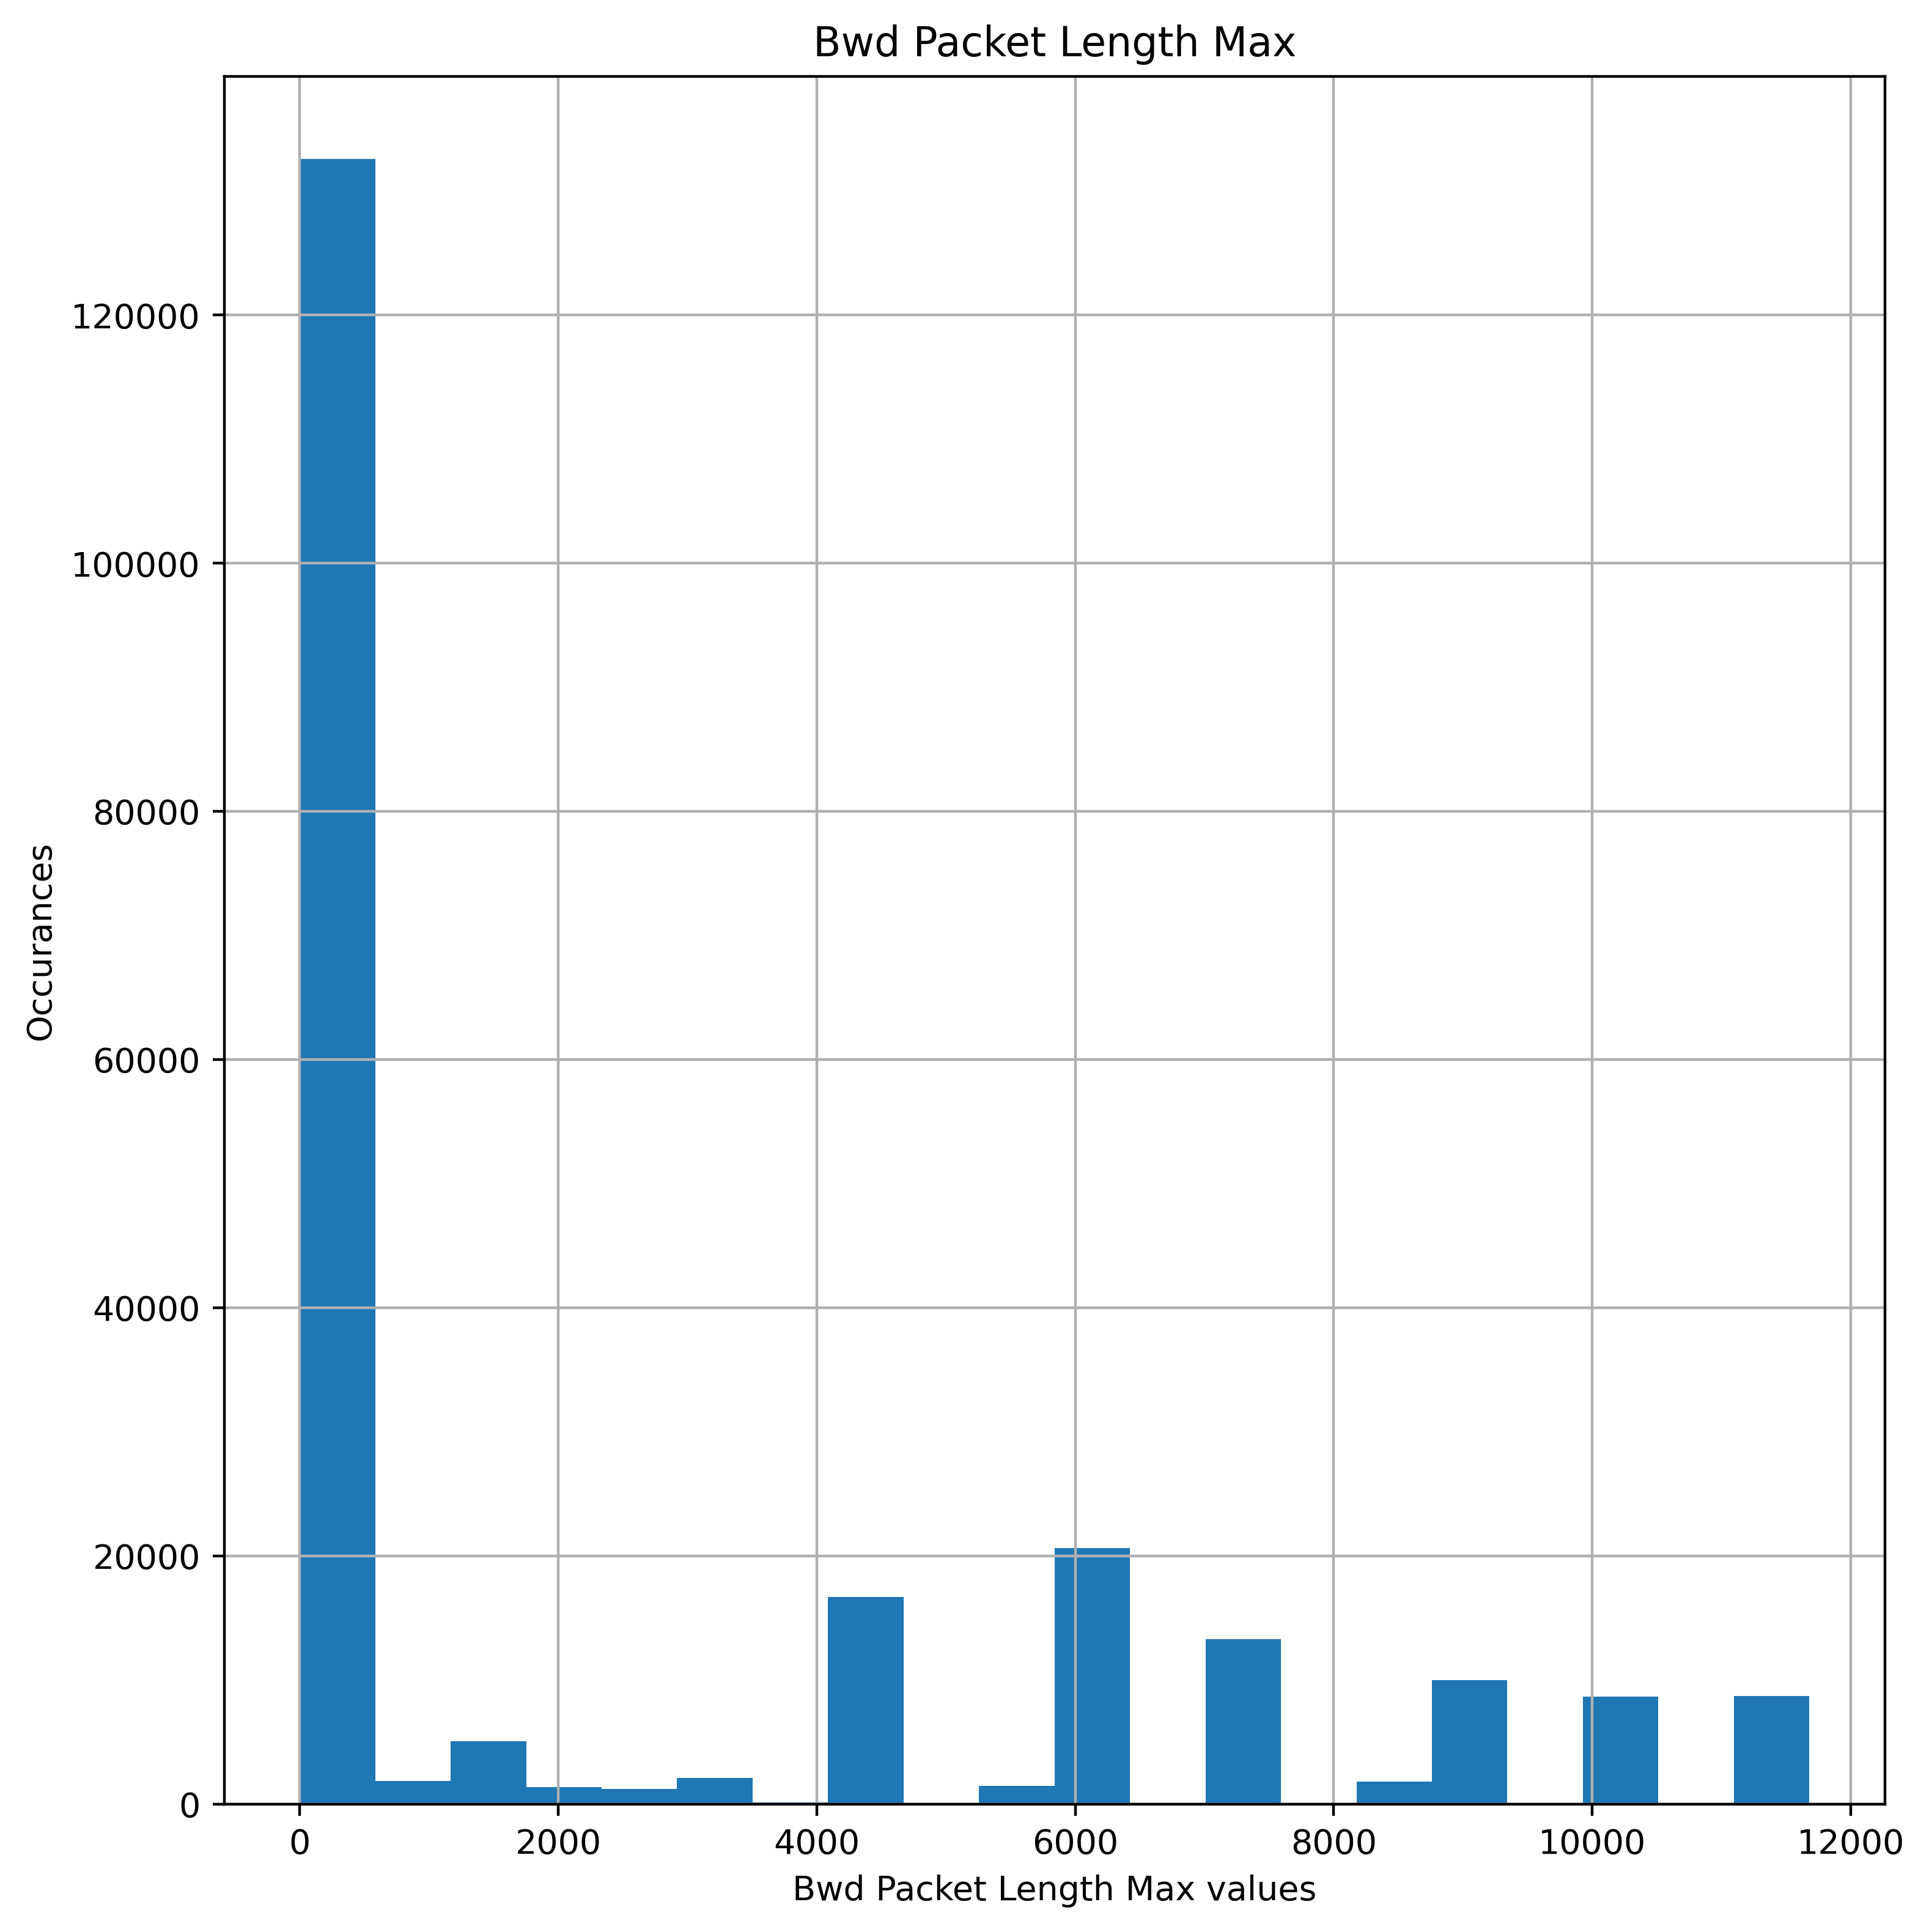

In [8]:
plot_hist(df1, "Bwd Packet Length Max")

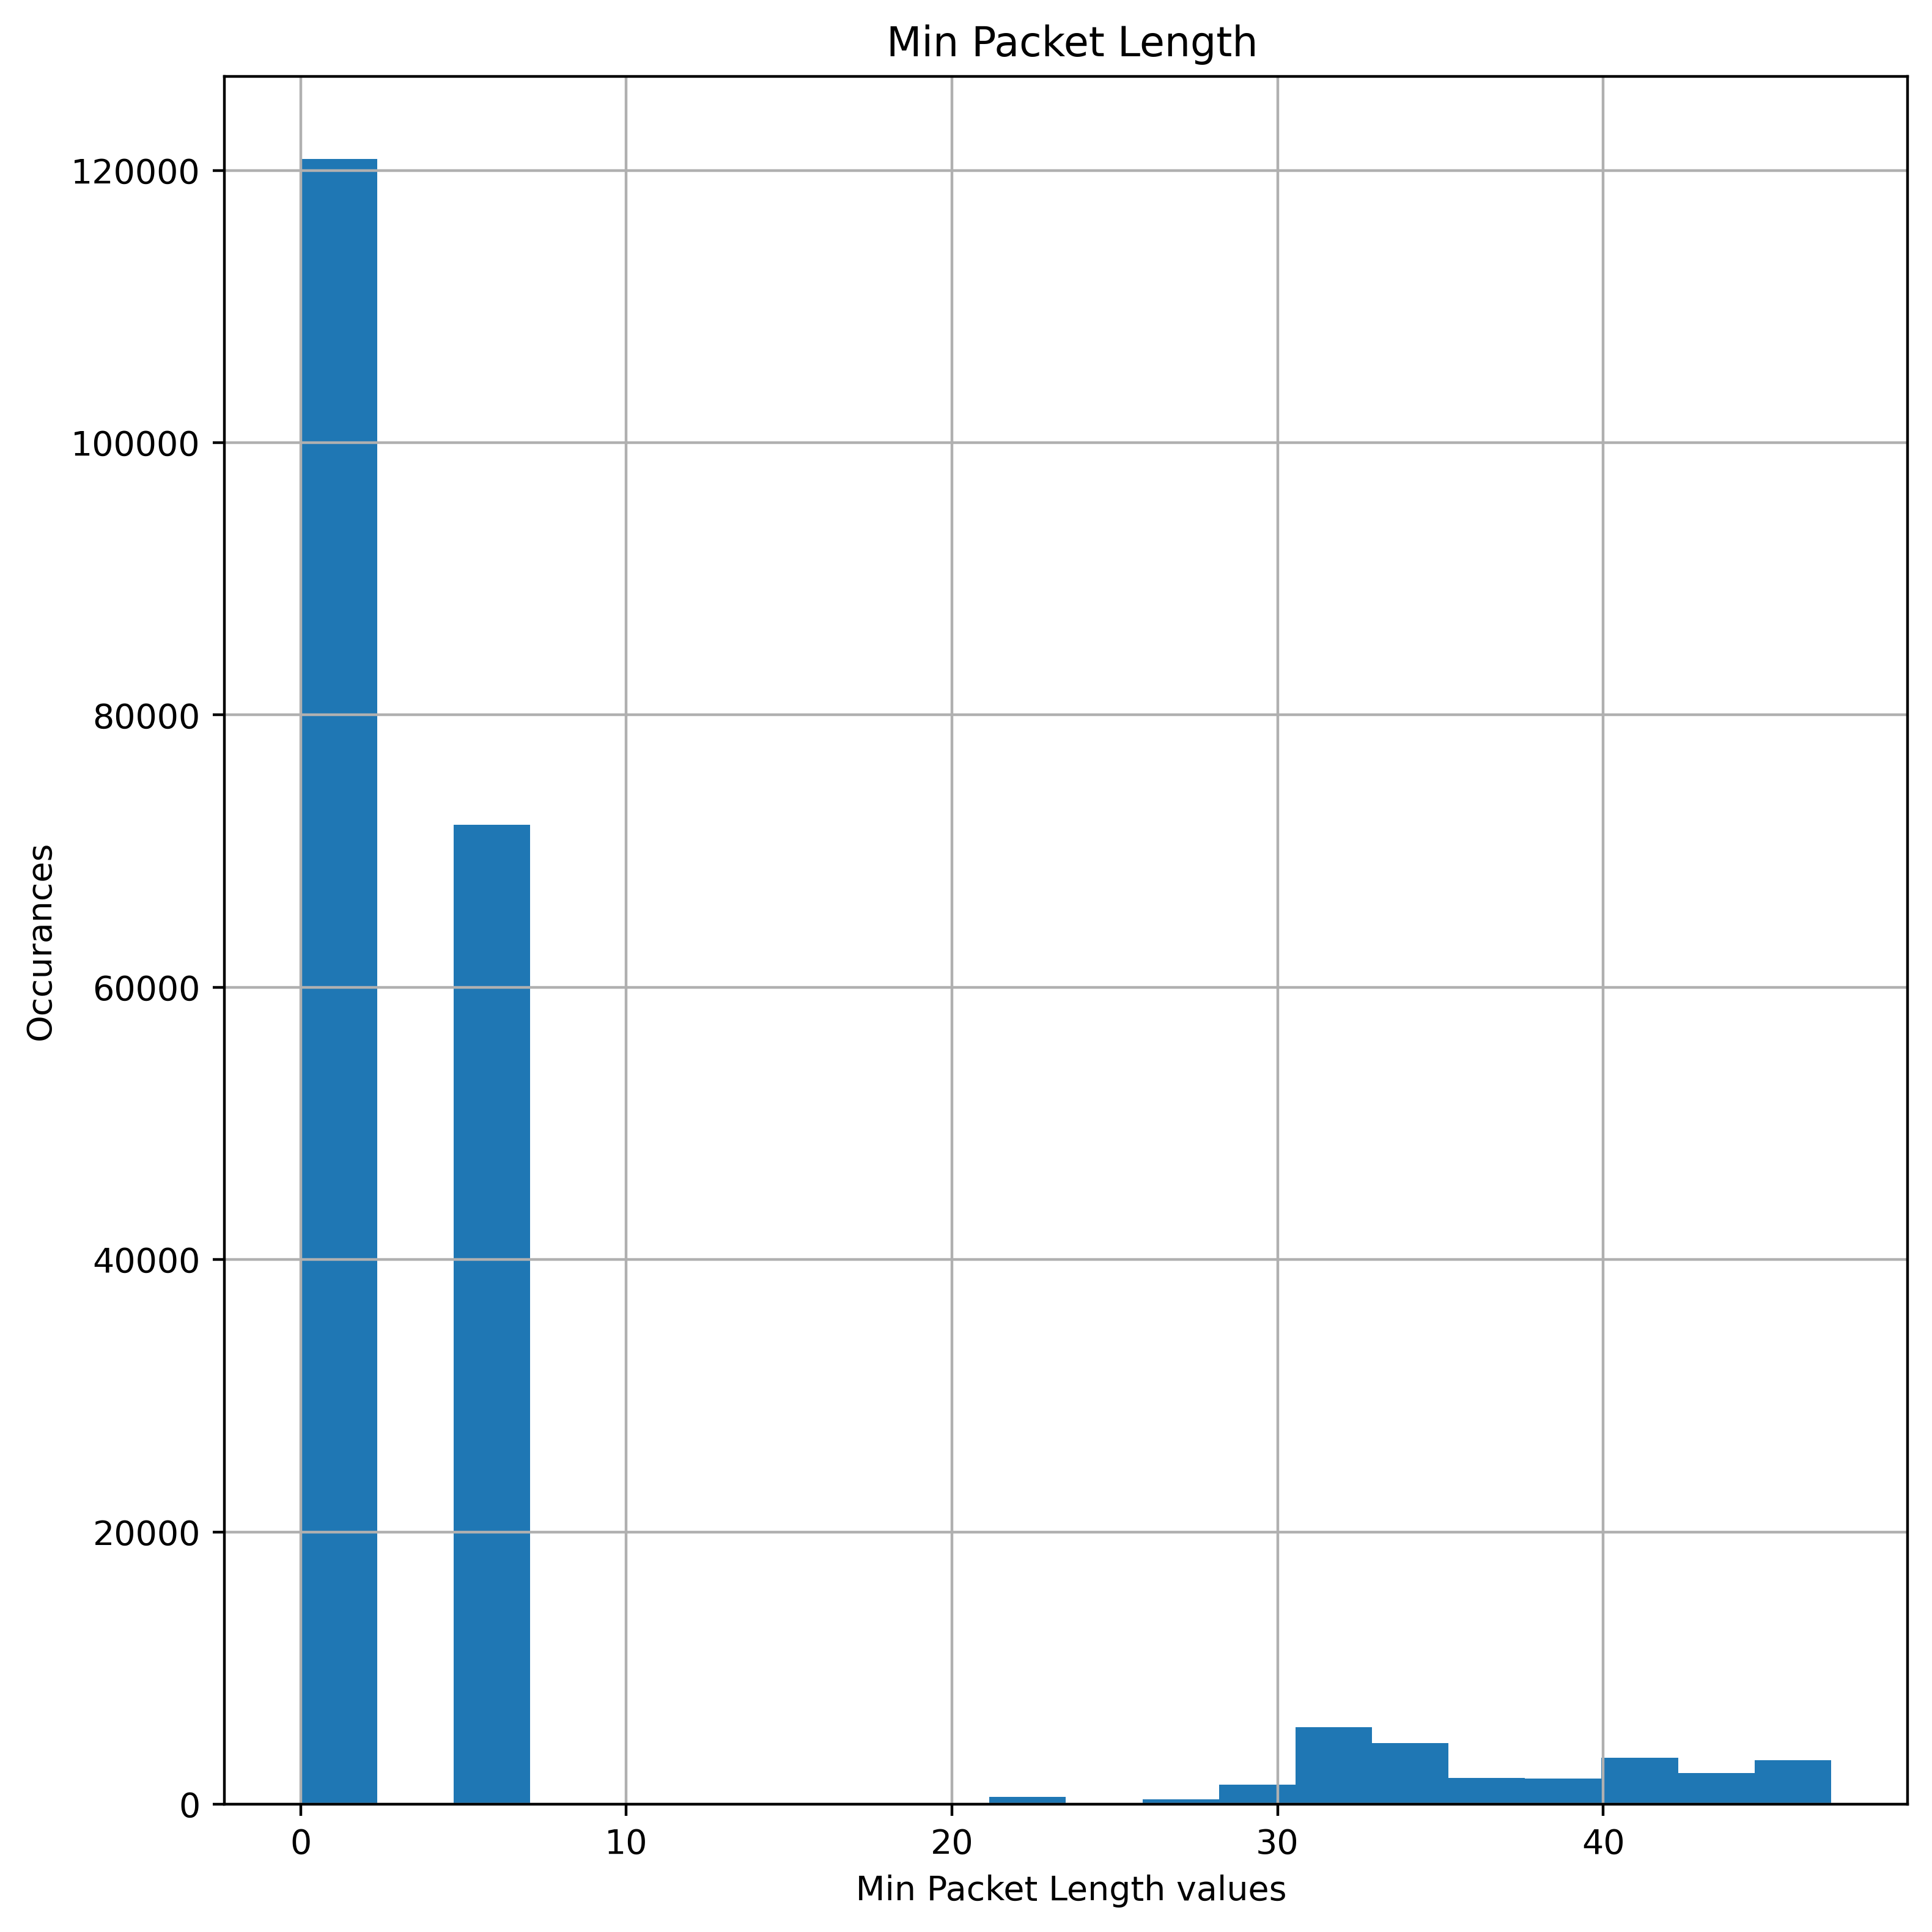

In [9]:
df1 = remove_outliers(df1, " Min Packet Length")
plot_hist(df1, " Min Packet Length")

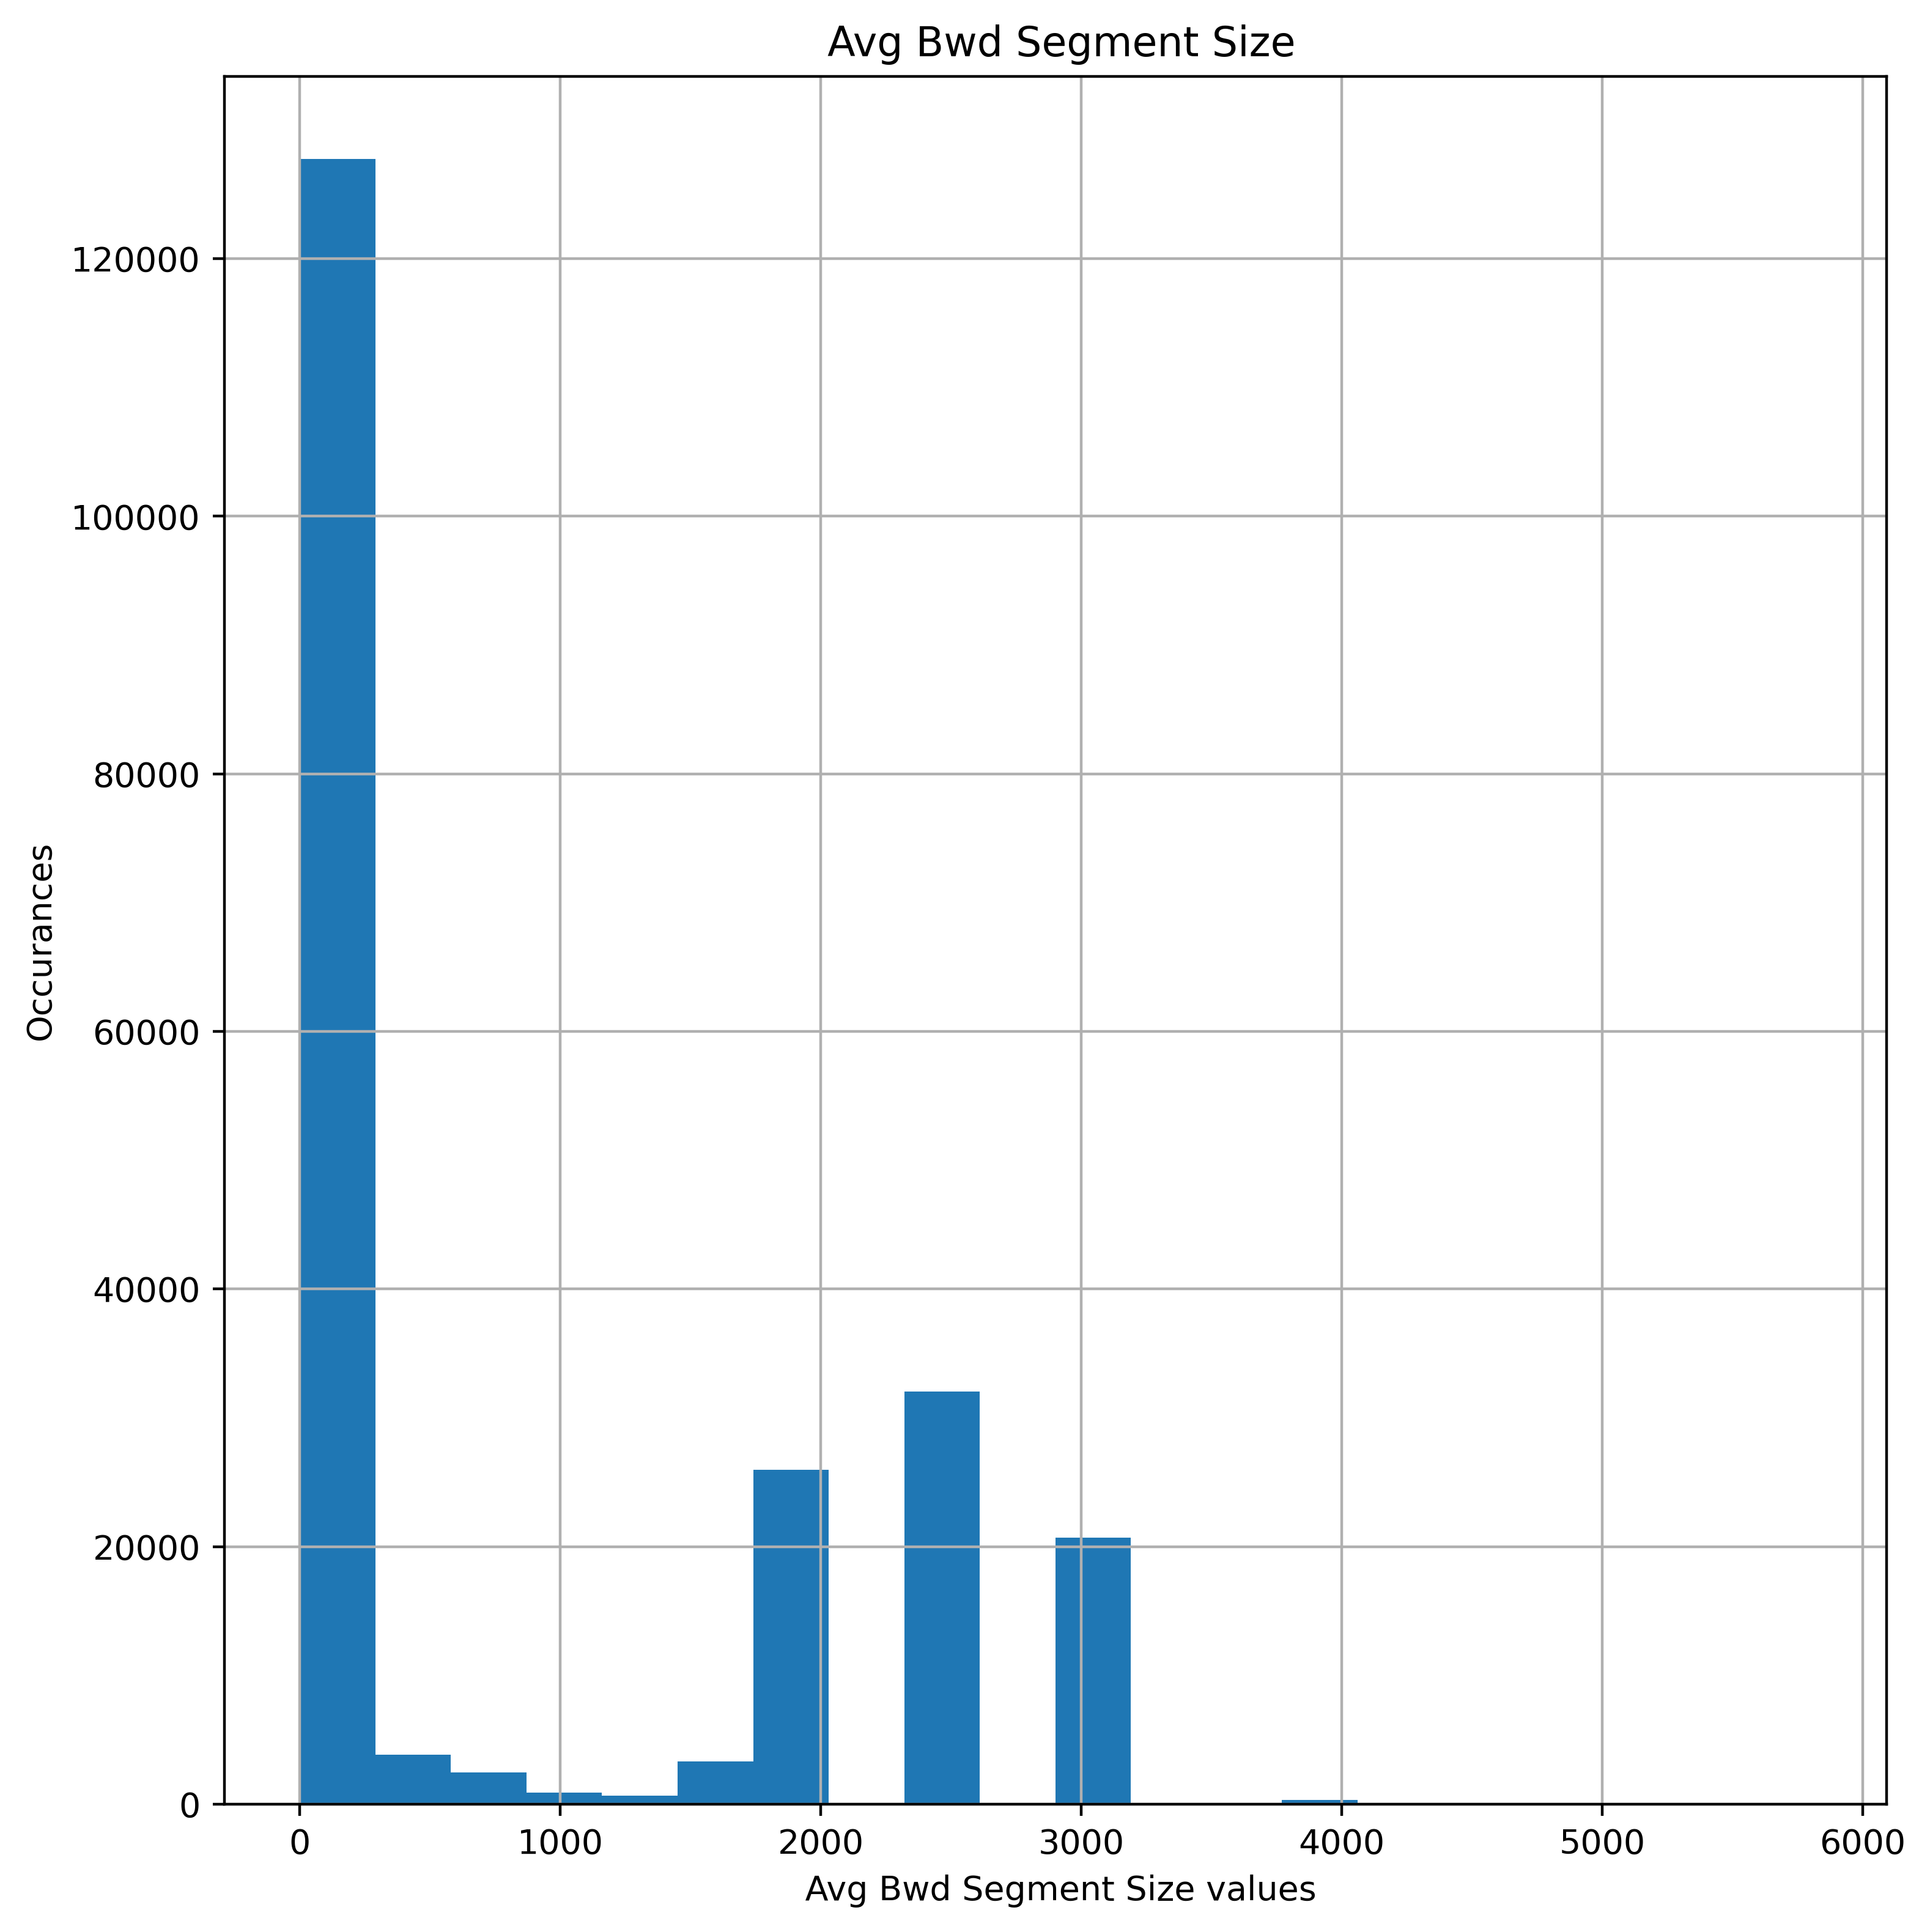

In [10]:
plot_hist(df1, " Avg Bwd Segment Size")

7. [10 pts] Attempt a few classifier models and report their 10-fold CV performances. 

In [11]:
## ONE-HOT ENCODE PORTS AND DROP IPS
df1 = pd.get_dummies(df1, columns=[' Source Port', ' Destination Port'])
df1 = df1.drop(columns=["Flow ID", " Source IP", " Destination IP", " Timestamp"])

## FINALIZE THE TRAINING SET
X = df1.drop(columns=[" Label"]).values
y = df1[" Label"].values

## TRAIN MODEL
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold    
from sklearn import metrics
import numpy as np 

def train(model_class, model_config, X, y, k=10, shuffle=False):
    ## K-FOLD CROSS VALIDATION
    acc, conf = [], []
    kfold = KFold(n_splits=k, shuffle=shuffle)
    for i_train, i_test in kfold.split(X, y):
        
        ## TRAIN MODEL
        model = model_class(**model_config)
        model.fit(X[i_train], y[i_train])
        y_pred = model.predict(X[i_test])

        ## COMPUTE METRICS
        conf.append(metrics.confusion_matrix(y[i_test], y_pred))
        acc.append(metrics.accuracy_score(y[i_test], y_pred))

    return acc, conf

In [12]:
## TRAIN RANDOM FOREST MODEL
model_config = {"n_estimators":10, "max_features":8}
acc, conf = train(RandomForestClassifier, model_config, X, y, k=10, shuffle=True)

## ANALYZE RESULTS
print(f"RANDOM FOREST: {dataset_1}")
print(f"Accuracy per fold: {'%, '.join(np.round(100*np.array(acc),2).astype(str))}")
print(f"10-Fold Mean Accuracy: {100*np.mean(acc):.4}%")

conf = np.array(conf)
tpr = conf[:, 0,0] / (conf[:, 0,0] + conf[:, 1,0] + 1e-10)
fpr = conf[:, 0,1] / (conf[:, 0,0] + conf[:, 0,1] + 1e-10)
print(f"10-Fold Mean True Positive Rate: {100*np.mean(tpr):.4}%")
print(f"10-Fold Mean False Positive Rate: {100*np.mean(fpr):.4}%")

RANDOM FOREST: ./TrafficLabelling/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Accuracy per fold: 99.98%, 99.99%, 100.0%, 100.0%, 99.99%, 100.0%, 100.0%, 99.99%, 100.0%, 99.99
10-Fold Mean Accuracy: 99.99%
10-Fold Mean True Positive Rate: 99.98%
10-Fold Mean False Positive Rate: 0.0%


8. [10 pts] Convert your code to be used for the remaining 7 datasets, i.e., Datasets 2-8. 

In [13]:
def clean_and_train(path):
    ## LOAD DATA
    df = pd.read_csv(path)

    ## CHECK LABELS
    n,f = df.shape
    classes = set(df[" Label"])

    ## DROP INVALID VALUES (inf)
    df["Flow Bytes/s"][df["Flow Bytes/s"] == np.inf] = np.nan
    df = df.dropna()    

    ## CHECK CLASS BALANCE
    class_balance = {key: round(100*len(df[df[" Label"] == key])/n, 3) for key in classes}
    print("CLASS BALANCE PERCENTAGES:", class_balance)
    df[" Label"][df[" Label"] != "BENIGN"] = 1
    df[" Label"][df[" Label"] == "BENIGN"] = 0
    df[" Label"] = df[" Label"].astype(int)
    
    ## ENCODE PORTS
    df[" Source Port"] = df[" Source Port"].apply(encode_port)
    df[" Destination Port"] = df[" Destination Port"].apply(encode_port)
    df = pd.get_dummies(df, columns=[' Source Port', ' Destination Port'])

    ## REMOVE OUTLIERS
    df = remove_outliers(df, " Min Packet Length")

    ## REMOVE IRRELEVANT FEATURES
    df = df.drop(columns=["Flow ID", " Source IP", " Destination IP", " Timestamp"])

    ## EXTRACT ARRAYS
    X = df1.drop(columns=[" Label"]).values
    y = df1[" Label"].values

    ## TRAIN RANDOM FOREST MODEL
    model_config = {"n_estimators":10, "max_features":8}
    acc, conf = train(RandomForestClassifier, model_config, X, y, k=10, shuffle=True)

    ## ANALYZE RESULTS
    print(f"RANDOM FOREST: {path}")
    print(f"Accuracy per fold: {'%, '.join(np.round(100*np.array(acc),2).astype(str))}")
    print(f"10-Fold Mean Accuracy: {100*np.mean(acc):.4}%")

    conf = np.array(conf)
    tpr = conf[:, 0,0] / (conf[:, 0,0] + conf[:, 1,0] + 1e-10)
    fpr = conf[:, 0,1] / (conf[:, 0,0] + conf[:, 0,1] + 1e-10)
    print(f"10-Fold Mean True Positive Rate: {100*np.mean(tpr):.4}%")
    print(f"10-Fold Mean False Positive Rate: {100*np.mean(fpr):.4}%")
    return 

9. [10 pts] Pick a classifier algorithm and report its evaluation for the remaining 7 datasets. Note that one dataset has a single class, which might need an unsupervised learning.  

In [14]:
clean_and_train("./TrafficLabelling/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")

CLASS BALANCE PERCENTAGES: {'BENIGN': 44.435, 'PortScan': 55.435}
RANDOM FOREST: ./TrafficLabelling/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Accuracy per fold: 99.99%, 100.0%, 99.98%, 99.99%, 99.98%, 99.98%, 100.0%, 99.99%, 99.99%, 99.98
10-Fold Mean Accuracy: 99.99%
10-Fold Mean True Positive Rate: 99.98%
10-Fold Mean False Positive Rate: 0.007725%


In [15]:
clean_and_train("./TrafficLabelling/Friday-WorkingHours-Morning.pcap_ISCX.csv")

CLASS BALANCE PERCENTAGES: {'BENIGN': 98.912, 'Bot': 1.024}
RANDOM FOREST: ./TrafficLabelling/Friday-WorkingHours-Morning.pcap_ISCX.csv
Accuracy per fold: 99.99%, 100.0%, 99.99%, 99.99%, 99.98%, 99.99%, 99.99%, 99.99%, 100.0%, 100.0
10-Fold Mean Accuracy: 99.99%
10-Fold Mean True Positive Rate: 99.98%
10-Fold Mean False Positive Rate: 0.00111%


In [16]:
clean_and_train("./TrafficLabelling/Monday-WorkingHours.pcap_ISCX.csv")

CLASS BALANCE PERCENTAGES: {'BENIGN': 99.918}
RANDOM FOREST: ./TrafficLabelling/Monday-WorkingHours.pcap_ISCX.csv
Accuracy per fold: 99.97%, 100.0%, 100.0%, 99.99%, 100.0%, 99.98%, 100.0%, 99.98%, 99.99%, 99.98
10-Fold Mean Accuracy: 99.99%
10-Fold Mean True Positive Rate: 99.98%
10-Fold Mean False Positive Rate: 0.005573%


In [17]:
clean_and_train("./TrafficLabelling/Tuesday-WorkingHours.pcap_ISCX.csv")

CLASS BALANCE PERCENTAGES: {'FTP-Patator': 1.78, 'SSH-Patator': 1.322, 'BENIGN': 96.839}
RANDOM FOREST: ./TrafficLabelling/Tuesday-WorkingHours.pcap_ISCX.csv
Accuracy per fold: 100.0%, 100.0%, 99.99%, 99.99%, 99.99%, 99.99%, 99.99%, 99.99%, 100.0%, 99.99
10-Fold Mean Accuracy: 99.99%
10-Fold Mean True Positive Rate: 99.98%
10-Fold Mean False Positive Rate: 0.003315%


In [18]:
clean_and_train("./TrafficLabelling/Wednesday-workingHours.pcap_ISCX.csv")

CLASS BALANCE PERCENTAGES: {'DoS slowloris': 0.837, 'BENIGN': 63.474, 'Heartbleed': 0.002, 'DoS GoldenEye': 1.486, 'DoS Slowhttptest': 0.794, 'DoS Hulk': 33.221}
RANDOM FOREST: ./TrafficLabelling/Wednesday-workingHours.pcap_ISCX.csv
Accuracy per fold: 99.99%, 100.0%, 99.99%, 99.99%, 99.99%, 99.99%, 99.99%, 99.99%, 99.99%, 100.0
10-Fold Mean Accuracy: 99.99%
10-Fold Mean True Positive Rate: 99.98%
10-Fold Mean False Positive Rate: 0.004381%


In [19]:
clean_and_train("./TrafficLabelling/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")

CLASS BALANCE PERCENTAGES: {'BENIGN': 99.916, 'Infiltration': 0.012}
RANDOM FOREST: ./TrafficLabelling/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Accuracy per fold: 99.98%, 99.99%, 99.99%, 99.99%, 99.99%, 100.0%, 99.98%, 99.99%, 99.99%, 100.0
10-Fold Mean Accuracy: 99.99%
10-Fold Mean True Positive Rate: 99.98%
10-Fold Mean False Positive Rate: 0.004428%


In [20]:
clean_and_train("./TrafficLabelling/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x96 in position 22398: invalid start byte

10. [10 pts] Briefly write up your thoughts about developing a machine learning model where you are not a subject matter expert, such as, developing a cybersecurity intrusion detection pipeline as in this assignment. 

Working with very specialized data in a field without expertise is a bit like stumbling around in the dark. Some of the tools and techniques we've learned let us shed a little bit of light on the problem, such as visualizing correlations, distributions, analyzing the nature of the features and labels, etc. And, while this may be enough to get a pretty good model for predicting the labels of these example datasets, I certainly would not expect the models developed here to generalize to detecting sophisticated, real world attacks they were not trained exposed to during training. 

Since I have no idea what the majority of the features correspond to, it is even difficult to determine what is redundant, what is critical, how features can be transformed (normalized) or how they should be encoded. This restricts the space of models I can even play around with to things like RandomForest, which are more forgiving in such situations. However, there may be many problems for which other models would be a better fit for acheiving optimal performance. 

The hints were very helpful for providing some ideas on approaches, and this is exactly the type of information conversing with a subject matter expert would provide. I believe that if the goal is to build a state-of-the-art ML model, a subject matter expert must be involved, or the ML engineer must spend enough time researching the domain they are working in enough to become somewhat of a subject matter expert themselves. 